### Imports

In [255]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
import numpy as np
import math

### Our weight calculation function

In [256]:
def calculate_w(train_x,degree):
    ones = np.ones([train_x.shape[0], 1])
    train_x = np.concatenate([ones, test_x],1)
    # create our polynomial
    for i in range(2, degree+1):
        # select the last column and put it to the i-th power
        n = np.array(train_x[:,1]**i)
        # insert that column
        train_x = np.append(train_x, n.reshape(-1,1), axis=1)
    w = np.linalg.inv(train_x.T.dot(train_x)).dot(train_x.T).dot(train_y)
    return w
    

### Loss Function
#### Mean Squared Error

In [257]:
def calculate_mse(true, pred):
    return np.mean((pred - true)**2)


### Our Linear Regression Function
#### Plots features vs outputs with a linear line 

In [285]:
def regression(w, x, y, degree, chart_title, k_fold=False,y_label='outputs', x_label='features'):
    # create our polynomial
    if not k_fold: 
        for i in range(2, degree+1):
            print(i)
            # select the last column and put it to the i-th power
            n = np.array(x[:,1]**i)
            # insert that column
            x = np.append(x, n.reshape(-1,1), axis=1)

    # do the same for our linspace
    space = np.linspace(min(x[:,1]),max(x[:,1])).reshape(-1,1)
    ones = np.ones([space.shape[0], 1])
    space = np.hstack((ones, space))
    for i in range(2, degree+1):
        n = np.array(space[:,1]**i)
        space = np.append(space, n.reshape(-1,1), axis=1)

    y_space = w.T.dot(space.T)

    # our equation looks like y = w^T*x + b
    # but we've added a column of ones to the x matrix, and so we can remove the bias from the equation
    y_pred = w.T.dot(x.T)
    # calc our error
    error = calculate_mse(y, y_pred.T)
    # plot the features and ouputs
    plt.scatter(x[:,1], y)
    # plot our line of fit
    plt.plot(space[:,1], y_space[0])
    # give the error
    plt.text(min(x[:,1]),min(y[:]),'MSE:%.8f'%error)
    # format the chart
    plt.title(chart_title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show()

### L2 Norm Regularization
#### Finding our training errors
##### (A good explanation: https://towardsdatascience.com/intuitions-on-l1-and-l2-regularisation-235f2db4c261)

In [270]:
def regularization(params, degree, train_x, train_y, test_x, test_y):
    # reshape the data
    train_x = train_x.reshape(-1,1)
    train_y = train_y.reshape(-1,1)
    test_x = test_x.reshape(-1,1)
    test_y = test_y.reshape(-1,1)
    
    ones = np.ones([train_x.shape[0], 1])
    train_x = np.hstack((ones, train_x))
    # create our polynomial
    for i in range(2, degree+1):
        # select the last column and put it to the i-th power
        n = np.array(train_x[:,1]**i)
        # insert that column
        train_x = np.append(train_x, n.reshape(-1,1), axis=1)
    
    ones = np.ones([test_x.shape[0], 1])    
    test_x = np.hstack((ones, test_x))
    # create our polynomial
    for i in range(2, degree+1):
         # select the last column and put it to the i-th power
        n = np.array(test_x[:,1]**i)
        # insert that column
        test_x = np.append(test_x, n.reshape(-1,1), axis=1)
    # make our identity matrix for applying our parameter
    i_hat=np.identity(degree+1)
    i_hat[0,0] = 0

    #loop through our params
    for idx, param in enumerate(params):
        # calculate our weights with regularized values
        w = np.linalg.inv(train_x.T.dot(train_x) + param*i_hat).dot(train_x.T).dot(train_y)
        # make our prediction on our test set
        y_pred_test = w.T.dot(test_x.T)
        # make our prediction on our test set
        y_pred_train = w.T.dot(train_x.T)
        test_error = calculate_mse(test_y, y_pred_test.T)
        train_error = calculate_mse(train_y, y_pred_train.T)
        plt.scatter(param, test_error, c='blue', label="test error")
        plt.scatter(param, train_error, c='red', label="train error")

    # get a descriptive title
    plt.title(f'polynomial degree {degree} regression with regularization')
    # we want our lambda to scale by 10^0, 10^1, etc..
    plt.xscale('log')
    # we want to plot our error vs our lambda parameter
    plt.ylabel('error')
    plt.xlabel('param')
    plt.show()

### K Fold Cross Validation and Polynomial Regression with L2 Norm Regression
#### (A good explanation: https://machinelearningmastery.com/k-fold-cross-validation/)
We shuffle the data set, and split it into k groups
* for each group:
  1. take out the i-th group as a validation set
  2. calculate your weights with the k-1 groups
  3. evaluate on the validation set

In [283]:
def k_group_cross_validation(k, params, train_x, train_y, test_x, test_y):
    # retain our original dataset
    full_train_x = train_x
    full_train_y = train_y
    # randomize our data, with the features and outputs still aligned on their indicies
    perm = np.random.permutation(len(train_x))
    train_x = train_x[perm]
    train_y = train_y[perm]
    indices = range(0, train_x.shape[0])
    # get the length of our data set, then divide it by our chosen k
    length = int(len(train_x)/k)
    errors = dict()
    # loop over our k groups
    for i in range(k):
        # get our validation indicies (the i-th group)
        validation_indices = list(range(i*length, i*length+length))
        # remove them from the indicies array, leaving us with our training data
        training_indices = np.delete(indices, validation_indices)
        train_x, validation_x = full_train_x[training_indices], full_train_x[validation_indices]
        train_y, validation_y = full_train_y[training_indices], full_train_y[validation_indices]
        # make our array for introducing paramater in our weight calculation
        i_hat=np.identity(5)
        i_hat[0,0] = 0
        # loop over our parameter array
        for idx, param in enumerate(params):
            w = np.linalg.inv(train_x.T.dot(train_x) + param*i_hat).dot(train_x.T).dot(train_y)
            # evaluate
            y_pred_train = w.T.dot(validation_x.T)
            # calculate the mse
            error = calculate_mse(validation_y, y_pred_train.T)
            if param in errors:
                # add the group error on this parameter to the dictionary
                errors[param].append(error)
            else:
                # otherwise start an entry for this parameter
                errors[param] = [error]
    # we want to compare against -inf
    lowest = float('inf')
    # this will hold our best param by lowest avg error
    best_param = 0
    # in this loop we go over our reported errors for each paramater and take the average
    # this gives us our best paramter that we will use for our regression
    for i in errors:
        avg = np.mean(errors[i])
        plt.scatter(i, avg)
        if avg < lowest:
            lowest_val = i
            best_param = avg
    plt.xlabel('param')
    plt.ylabel('error')
    plt.xscale('log')
    plt.title('average error on validation set')
    plt.show()
    # calculate our weights with the best param
    w = np.linalg.inv(full_train_x.T.dot(full_train_x) + best_param*i_hat).dot(full_train_x.T).dot(full_train_y)
    regression(w, test_x, test_y, 4,'polynomial degree 4 regression with cross-validation and regularization', True)

### Generate some data
Gives us some random points that we can evaulate and play with

In [262]:
training_features, training_outputs  = make_regression(n_samples=200, n_features=1, noise=30)
test_features, test_outputs  = make_regression(n_samples=200, n_features=1, noise=20)

### Lets look at the relationship, and get a visual

/home/jake/Documents/4442/ass1/env/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


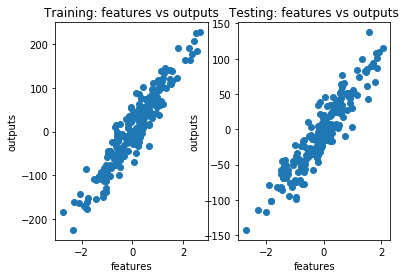

In [287]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.scatter(training_features, training_outputs)
ax1.set_title('Training: features vs outputs')
ax1.set_ylabel('outputs')
ax1.set_xlabel('features')
ax2.scatter(test_features, test_outputs)
ax2.set_title('Testing: features vs outputs')
ax2.set_ylabel('outputs')
ax2.set_xlabel('features')
fig.show()

### Now lets do some linear regression using our defined function

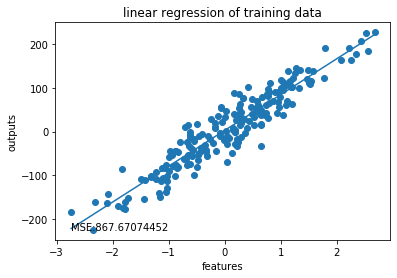

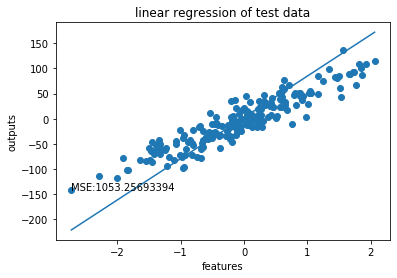

In [288]:
# reshape the data into column vectors
train_x = training_features.reshape(-1,1)
train_y = training_outputs.reshape(-1,1)
test_x = test_features.reshape(-1,1)
test_y = test_outputs.reshape(-1,1)

# concat the ones arrays
ones = np.ones([train_x.shape[0], 1])
train_x = np.concatenate([ones, train_x],1)
# calculate our weight vector
w = np.linalg.inv(train_x.T.dot(train_x)).dot(train_x.T).dot(train_y)
# now call our regression functin, passing in our data to plot
regression(w, train_x, train_y, 1, 'linear regression of training data')

# now for our test data
ones = np.ones([test_x.shape[0], 1])
test_x = np.concatenate([ones, test_x],1)
regression(w, test_x, test_y, 1, 'linear regression of test data')


2


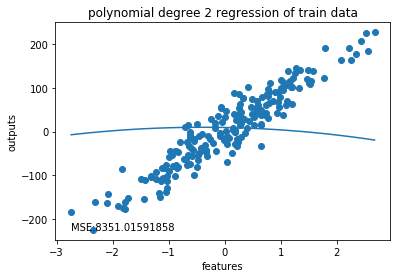

2


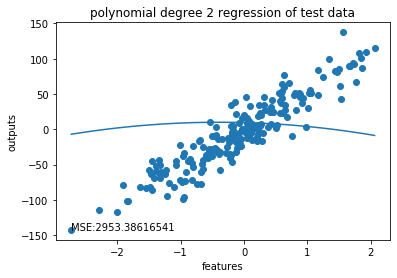

In [289]:
# reshape the data into column vectors
train_x = training_features.reshape(-1,1)
train_y = training_outputs.reshape(-1,1)
test_x = test_features.reshape(-1,1)
test_y = test_outputs.reshape(-1,1)

# now call our regression functin, passing in our data to plot

w = calculate_w(train_x, 2)
ones = np.ones([train_x.shape[0], 1])
train_x = np.concatenate([ones, train_x],1)
regression(w, train_x, train_y, 2, 'polynomial degree 2 regression of train data')

ones = np.ones([test_x.shape[0], 1])
test_x = np.concatenate([ones, test_x],1)
# now for our test data
regression(w, test_x, test_y, 2, 'polynomial degree 2 regression of test data')


### The error is just about the same, so its doubtful that a higher degree polynomial will 

2
3


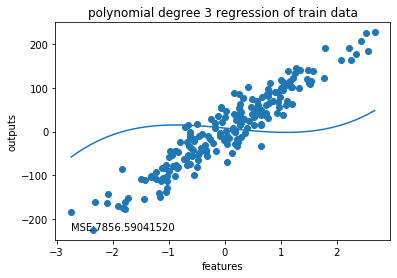

2
3


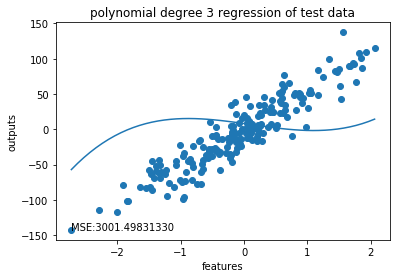

In [290]:
# reshape the data into column vectors
train_x = training_features.reshape(-1,1)
train_y = training_outputs.reshape(-1,1)
test_x = test_features.reshape(-1,1)
test_y = test_outputs.reshape(-1,1)

# now call our regression functin, passing in our data to plot

w = calculate_w(train_x, 3)
ones = np.ones([train_x.shape[0], 1])
train_x = np.concatenate([ones, train_x],1)
regression(w, train_x, train_y, 3, 'polynomial degree 3 regression of train data')

ones = np.ones([test_x.shape[0], 1])
test_x = np.concatenate([ones, test_x],1)
# now for our test data
regression(w, test_x, test_y, 3, 'polynomial degree 3 regression of test data')

### Lets see if the 4th degree polynomial fits better

2
3
4


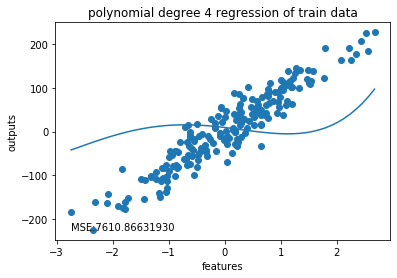

2
3
4


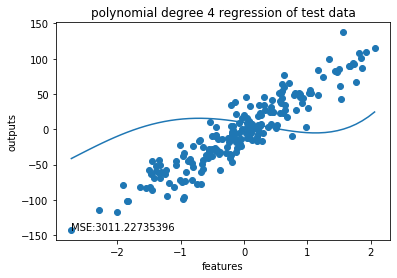

In [291]:
# reshape the data into column vectors
train_x = training_features.reshape(-1,1)
train_y = training_outputs.reshape(-1,1)
test_x = test_features.reshape(-1,1)
test_y = test_outputs.reshape(-1,1)

# now call our regression functin, passing in our data to plot

w = calculate_w(train_x, 4)
ones = np.ones([train_x.shape[0], 1])
train_x = np.concatenate([ones, train_x],1)
regression(w, train_x, train_y, 4, 'polynomial degree 4 regression of train data')

ones = np.ones([test_x.shape[0], 1])
test_x = np.concatenate([ones, test_x],1)
# now for our test data
regression(w, test_x, test_y, 4, 'polynomial degree 4 regression of test data')

### It seems like we are overfitting on our training data, set let's try using regularization

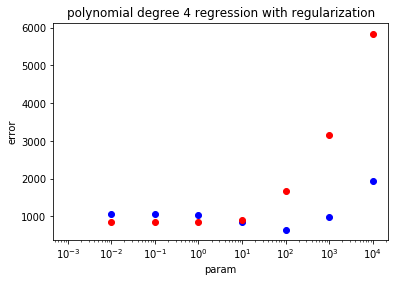

In [271]:
regularization(params, 4, training_features, training_outputs, test_features, test_outputs)

### It seems like we do best with a lower parameter, now lets try to find the best weight

### Lets try using k-fold cross-validation, with k=5
#### This should help us get a better fit

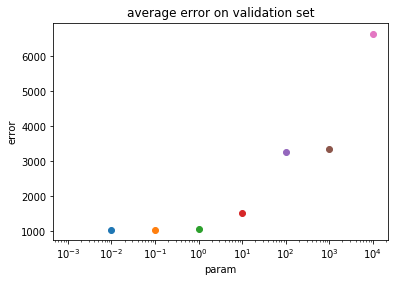

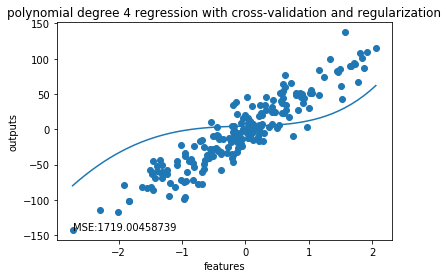

In [292]:
# reshape the data
train_x = training_features.reshape(-1,1)
train_y = training_outputs.reshape(-1,1)
test_x = test_features.reshape(-1,1)
test_y = test_outputs.reshape(-1,1)

ones = np.ones([train_x.shape[0], 1])
train_x = np.hstack((ones, train_x, train_x**2, train_x**3, train_x**4))
ones = np.ones([test_x.shape[0], 1])
test_x = np.hstack((ones, test_x, test_x**2, test_x**3, test_x**4))
parameters=[0.01,0.1,1,10,100,1000,10000]
k_group_cross_validation(5, parameters, train_x, train_y, test_x, test_y)

### An okay fit, but still not as good as our linear model. 

### In conclusion, the benefits of polynomial regression are seen when the data emulates a polynomial distribution, and less so when the distribution emulates a linear equation.